In [1]:
%load_ext autoreload
%autoreload 2

### Baseline LLM text-classification with Langchain

**Experiments**
- model :
    - pipeline_kwargs
        - temperature, do_sample
        - max_new_tokens
    - benchmark differents modeles
- dataset : truncated quotes vs not
- prompt : engineering

In [2]:
from frugalai.utils.efficiency_tracker import FunctionTracker

tracker = FunctionTracker()

##### **Load dataset**

In [3]:
from datasets import load_dataset

@tracker.track
def load_frugalai_dataset():
    ds = load_dataset("QuotaClimat/frugalaichallenge-text-train")
    ds = ds.select_columns(['quote', 'label'])
    ds = ds['train']
    return ds

ds = load_frugalai_dataset()
print(type(ds))
print(ds.shape)
print()


⏳ FunctionTimer: load_frugalai_dataset
| time            00:00:11.1327
| emissions       0.000001 CO2eq
| energy consumed 0.000012 kWh

<class 'datasets.arrow_dataset.Dataset'>
(4872, 2)



##### **Sample a balanced subset**

In [4]:
from frugalai.utils.analytics import print_distribution

print_distribution(ds)


🔹 Label distribution (dataset.Dataset):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          1311      26.91%
1_not_happening                         587       12.05%
2_not_human                             565       11.6%
3_not_bad                               289       5.93%
4_solutions_harmful_unnecessary         614       12.6%
5_science_unreliable                    641       13.16%
6_proponents_biased                     643       13.2%
7_fossil_fuels_needed                   222       4.56%
------------------------------------------------------------
Total                                   4872      


In [5]:
from frugalai.utils.sampling import sample_balanced_subset

N = 50
subset_ds = sample_balanced_subset(ds, N=N, seed=42)

print(subset_ds)
print_distribution(subset_ds)

Dataset({
    features: ['quote', 'label'],
    num_rows: 48
})

🔹 Label distribution (dataset.Dataset):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          6         12.5%
1_not_happening                         6         12.5%
2_not_human                             6         12.5%
3_not_bad                               6         12.5%
4_solutions_harmful_unnecessary         6         12.5%
5_science_unreliable                    6         12.5%
6_proponents_biased                     6         12.5%
7_fossil_fuels_needed                   6         12.5%
------------------------------------------------------------
Total                                   48        


##### **Limit quote size**

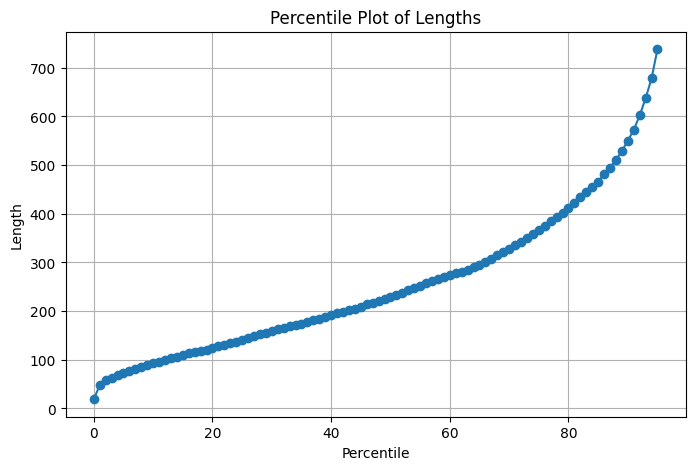

In [6]:
import numpy as np
import matplotlib.pyplot as plt

lenghts = [len(quote) for quote in ds['quote']]

# Compute percentiles
x = range(96)
percentiles = [np.percentile(lenghts, i) for i in x]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, percentiles, marker='o', linestyle='-')
plt.xlabel("Percentile")
plt.ylabel("Length")
plt.title("Percentile Plot of Lengths")
plt.grid(True)
plt.show()


In [7]:
np.percentile(lenghts, 50)

np.float64(229.0)

In [8]:
from scipy.stats import percentileofscore
percentileofscore(lenghts, 350, kind='rank')

np.float64(73.07060755336617)

In [9]:
threshold = 350

# Add a truncated quote column
def add_truncated_quote(example):
    example["trunc_quote"] = example["quote"][:threshold]
    return example

subset_ds = subset_ds.map(add_truncated_quote)
subset_ds

Dataset({
    features: ['quote', 'label', 'trunc_quote'],
    num_rows: 48
})

In [10]:
X_test = subset_ds["trunc_quote"]
y_test = subset_ds["label"]
len(X_test), len(y_test)

(48, 48)

##### **Load model**

In [17]:
# Select Model
MODEL_NAMES = {
    "mistral": "TheBloke/Mistral-7B-Instruct-v0.2-GGUF",
    "phi3": "microsoft/Phi-3-mini-4k-instruct",
    "qwen": "Qwen/Qwen2.5-0.5B-Instruct"
}
selected_model = "phi3"
model_name = MODEL_NAMES[selected_model]
model_name

'microsoft/Phi-3-mini-4k-instruct'

In [13]:
from frugalai.utils.monitoring import model_cache_state

model_cache_state()

📁 Hugging Face Model Cache: /Users/a.villa.massone/.cache/huggingface/hub

📌 28.97 GB	| models--mistralai--Mistral-7B-Instruct-v0.1
📌 15.29 GB	| models--microsoft--Phi-3-mini-4k-instruct
📌 3.26 GB	| models--facebook--bart-large-mnli
📌 2.00 GB	| models--Qwen--Qwen2.5-0.5B
📌 2.00 GB	| models--Qwen--Qwen2.5-0.5B-Instruct
📌 30.49 GB	| models--Qwen--Qwen2.5-7B
📌 7.12 GB	| models--deepseek-ai--DeepSeek-R1-Distill-Qwen-1.5B

🛑 Total Cache Size: 89.13 GB


       Token Count
count    48.000000
mean     67.687500
std      40.600889
min      18.000000
25%      42.000000
50%      55.500000
75%      79.750000
max     208.000000
114.50000000000003


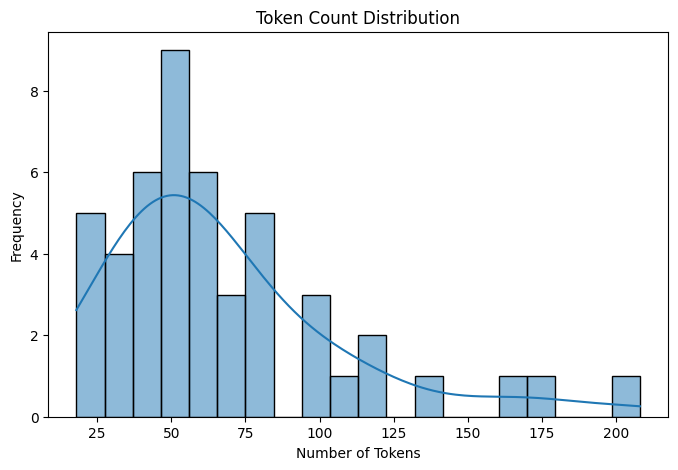

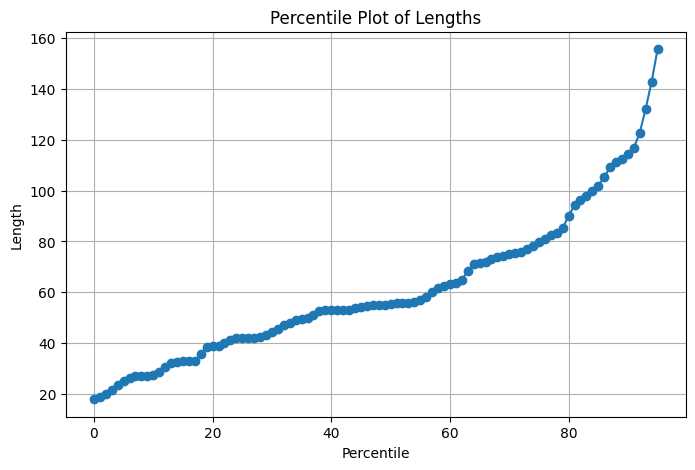

In [18]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load a tokenizer (replace with your model's tokenizer)
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Change to your model

# Tokenize and count tokens
token_counts = [len(tokenizer.encode(text, truncation=False)) for text in subset_ds["quote"]]
x = range(96)
token_percentiles = [np.percentile(token_counts, i) for i in x]

# Create a dataframe for visualization
df = pd.DataFrame({"Text": subset_ds["quote"], "Token Count": token_counts})

# Display dataset statistics
print(df.describe())  # Summary statistics
print(np.percentile(df['Token Count'], 90))

# Plot token distribution
plt.figure(figsize=(8, 5))
sns.histplot(token_counts, bins=20, kde=True)
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Token Count Distribution")
plt.show()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, token_percentiles, marker='o', linestyle='-')
plt.xlabel("Percentile")
plt.ylabel("Length")
plt.title("Percentile Plot of Lengths")
plt.grid(True)
plt.show()


In [19]:
from langchain_huggingface import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
import os

    #"batch_size": 8,  # Process 8 quotes at a time
 #   'torch_dtype':"auto",  
  #  'trust_remote_code':True, 
#    "return_full_text": False, 
#    "device_map":"auto",



@tracker.track
def load_model(model_name, pipeline_kwargs):
    torch.mps.empty_cache()
    
    model = AutoModelForCausalLM.from_pretrained(model_name)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.max_length = 2
    tokenizer.truncation = True
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    pipe = pipeline(
        "text-generation", 
        model=model, 
        tokenizer=tokenizer,
        
        **pipeline_kwargs
    )
        
    llm = HuggingFacePipeline(pipeline=pipe)
    llm_engine = ChatHuggingFace(llm=llm)
    return llm_engine

pipeline_kwargs = {
    "max_new_tokens": 2,
    "top_k": 50,
    "do_sample": False,
}
    
model = load_model(model_name, pipeline_kwargs)
print(type(model))
print()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0
hugg


⏳ FunctionTimer: load_model
| time            00:00:45.6254
| emissions       0.000005 CO2eq
| energy consumed 0.000083 kWh

<class 'langchain_huggingface.chat_models.huggingface.ChatHuggingFace'>



In [20]:
model

ChatHuggingFace(llm=HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x315bd1a90>, model_id='microsoft/Phi-3-mini-4k-instruct'), tokenizer=LlamaTokenizerFast(name_or_path='microsoft/Phi-3-mini-4k-instruct', vocab_size=32000, model_max_length=4096, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '<|endoftext|>', 'unk_token': '<unk>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=False),
	32000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<|assistant|>", 

In [21]:
model.llm

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x315bd1a90>, model_id='microsoft/Phi-3-mini-4k-instruct')

In [22]:
model.llm.pipeline

In [23]:
model.llm.pipeline.generation_config

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000
}

In [24]:
model.llm.pipeline.tokenizer

LlamaTokenizerFast(name_or_path='microsoft/Phi-3-mini-4k-instruct', vocab_size=32000, model_max_length=4096, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '<|endoftext|>', 'unk_token': '<unk>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=False),
	32000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<|assistant|>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=True),
	32002: AddedToken("<|placeholder1|>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=Tr

In [25]:
model.llm.pipeline.model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=3072, out_features=32064, 

In [26]:
from frugalai.utils.monitoring import model_memory_need

model_memory_need(model=model)

{'model_name': 'microsoft/Phi-3-mini-4k-instruct',
 'model_type': transformers.models.phi3.modeling_phi3.Phi3ForCausalLM,
 'total_params_Billion': 3.82,
 'precision': torch.float32,
 'estimated_memory_gb': 15.28}

In [27]:
from frugalai.utils.monitoring import pytorch_print_cache

pytorch_print_cache()

Allocated by MPS: 15.28 GB
Allocated by driver: 16.11 GB
Available system memory: 4.61 GB


##### **Tests**

In [ ]:
%%time
# Test with basic message
response = model.invoke("Hugging Face is")
print("\noutput type :\n", type(response))
print("\nfull output :\n", response)
print("\ncontent :\n", response.content)
print()

##### **Prompt template**

In [28]:
# PromptTemplate
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
#Do not output any additional text, spaces, or punctuation.
#Your answer must consist of exactly one token -  a digit from 0 to 7 - corresponding to the category detected. 

system_template = f"""
Your task is to classify statements into 8 categories.
Respond STRICTLY with only the corresponding number. 
DO NOT INCLUDE ANY OTHER TEXT.
"""

prompt_template = f"""
<instruction>
Classify the following statement into one of these 8 categories:
If you do not know the answer, make your best guess.
</instruction>

<categories>
0 - Not relevant: No climate-related claims or doesn't fit other categories
1 - Denial: Claims climate change is not happening
2 - Attribution denial: Claims human activity is not causing climate change
3 - Impact minimization: Claims climate change impacts are minimal or beneficial
4 - Solution opposition: Claims solutions to climate change are harmful
5 - Science skepticism: Challenges climate science validity or methods
6 - Actor criticism: Attacks credibility of climate scientists or activists
7 - Fossil fuel promotion: Asserts importance of fossil fuels
</categories>

<statement>
Statement: "{{quote}}"
</statement>

Category number:"""

# Create the prompt template
prompt = PromptTemplate(template=prompt_template, input_variables=["quote"])

prompt = ChatPromptTemplate([
    ("system", system_template),
    ("user", prompt_template)
])
prompt

ChatPromptTemplate(input_variables=['quote'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='\nYour task is to classify statements into 8 categories.\nRespond STRICTLY with only the corresponding number. \nDO NOT INCLUDE ANY OTHER TEXT.\n'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['quote'], input_types={}, partial_variables={}, template='\n<instruction>\nClassify the following statement into one of these 8 categories:\nIf you do not know the answer, make your best guess.\n</instruction>\n\n<categories>\n0 - Not relevant: No climate-related claims or doesn\'t fit other categories\n1 - Denial: Claims climate change is not happening\n2 - Attribution denial: Claims human activity is not causing climate change\n3 - Impact minimization: Claims climate change impacts are minimal or beneficial\n4 - Solution opposition: Claims so

##### **Output parser**

In [29]:
# StrOutputParser
from langchain_core.output_parsers import StrOutputParser
import re
# Class Labels
CLASS_LABELS = [
    "0_not_relevant", "1_not_happening", "2_not_human", "3_not_bad",
    "4_solutions_harmful_unnecessary", "5_science_unreliable",
    "6_proponents_biased", "7_fossil_fuels_needed"
]

# Define an output parser for cleaning up the response
class CustomOutputParser(StrOutputParser):
    def parse(self, text: str) -> int:
        parts = text.split('</statement>')
        if len(parts) > 1:
            _match = re.search(r'\d', parts[-1])
            if _match:
                response = _match.group()
                if response.isdigit() and int(response) in range(8):  
                    return CLASS_LABELS[int(response)]
        return '-1'

    
# Create the output parser
output_parser = CustomOutputParser()

##### **Chain**

In [30]:
# Chain
chain = prompt | model | output_parser
type(chain)

langchain_core.runnables.base.RunnableSequence

##### **tests on chain**

In [ ]:
%%time
# Example statement
statement = "Climate change is just a hoax created to control people."
output = chain.invoke({"quote": statement})

print("\nstatement :\n", statement)
print("\noutput type :", type(output))
print("\ncategory :", output)
print()

In [ ]:
%%time
# test for one quote
for x, y in zip(X_test, y_test):
    quote = x
    label = y
    break
print("quote :\n", quote)
print("label :", label)

response = chain.invoke({"quote": quote})
print("\nprediction :", response)
print()

##### **Batch inference**

In [31]:
from tqdm import tqdm

@tracker.track
def inference(quotes):
    y_pred = []
    for quote in tqdm(quotes, desc="Inference"):
        y_pred.append(chain.invoke({"quote": quote}))
    print()
    return y_pred

y_pred = inference(X_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 



⏳ FunctionTimer: inference
| time            00:01:25.2562
| emissions       0.000018 CO2eq
| energy consumed 0.000325 kWh



In [ ]:
# batch prend bcp trop de temps
#%%time
#import pandas as pd

#batch_X_test = pd.Series(X_test).apply(lambda quote : {"quote": quote})
#print('batch_X_test', type(batch_X_test), len(batch_X_test))
#batch_X_test[:5]
#y_pred = chain.batch(batch_X_test.tolist())

#y_pred_s = pd.Series(y_pred)
#y_pred_s

##### **Evaluation**

In [32]:
from frugalai.utils.evaluation import create_results_df

results_df = create_results_df(X_test, y_test, y_pred)
results_df.head()

,X_test,y_test,y_pred,correct
0,State attorneys general are supposed to enforc...,0_not_relevant,7_fossil_fuels_needed,False
1,ExxonMobil is currently the worst of the oil g...,0_not_relevant,7_fossil_fuels_needed,False
2,"Call it the new Great New Reset, New World Ord...",0_not_relevant,0_not_relevant,True
3,Cool Clouded Fact: The idea of climate change ...,0_not_relevant,1_not_happening,False
4,Oil money has also contributed to the network ...,0_not_relevant,7_fossil_fuels_needed,False


In [33]:
from frugalai.utils.evaluation import performance_breakdown

performance = performance_breakdown(results_df)
performance

,Outcome,Count
0,Correct,26
1,Incorrect,22
2,Unknown,0
3,Error,0


In [34]:
print_distribution(y_test)
print_distribution(y_pred)


🔹 Label distribution (list):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          6         12.5%
1_not_happening                         6         12.5%
2_not_human                             6         12.5%
3_not_bad                               6         12.5%
4_solutions_harmful_unnecessary         6         12.5%
5_science_unreliable                    6         12.5%
6_proponents_biased                     6         12.5%
7_fossil_fuels_needed                   6         12.5%
------------------------------------------------------------
Total                                   48        

🔹 Label distribution (list):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          3         6.25%
1_not_happening                         7         14.58%
2_not_human            

In [35]:
from frugalai.utils.evaluation import evaluation

accuracy, metrics_df = evaluation(y_test, y_pred)

print('accuracy :', round(accuracy, 2))

accuracy : 0.54


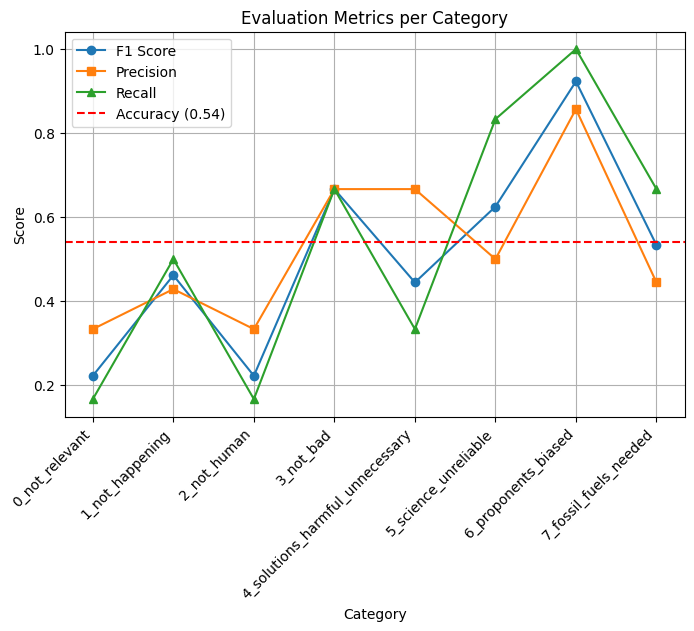

Category metrics
                          Category  Precision  Recall  F1 Score
0                   0_not_relevant       0.33    0.17      0.22
1                  1_not_happening       0.43    0.50      0.46
2                      2_not_human       0.33    0.17      0.22
3                        3_not_bad       0.67    0.67      0.67
4  4_solutions_harmful_unnecessary       0.67    0.33      0.44
5             5_science_unreliable       0.50    0.83      0.62
6              6_proponents_biased       0.86    1.00      0.92
7            7_fossil_fuels_needed       0.44    0.67      0.53



In [36]:
from frugalai.utils.evaluation import plot_metrics

plot_metrics(accuracy, metrics_df)

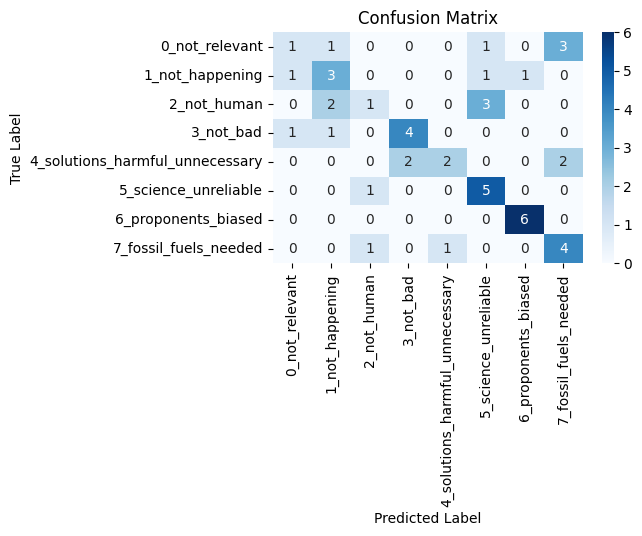

In [37]:
from frugalai.utils.evaluation import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred)

##### **Experiment recording**

In [38]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
timestamp

'2025-02-25_16:19:55'

In [39]:
tracker.get_metrics()

,Timings (seconds),Emissions (CO2eq),Energy (kWh)
load_frugalai_dataset,11.132708,6.954246e-07,0.000012
load_model,45.625425,4.651792e-06,0.000083
inference,85.256222,1.822066e-05,0.000325
Total,142.014356,2.356788e-05,0.000421


In [40]:
import json
import pprint

meta_data = {
    "model_name": model_name,
    "accuracy": round(accuracy, 2),
    "timestamp": timestamp,
    
    "model_details": model_memory_need(model=model),
    "pipeline_kwargs": pipeline_kwargs,

    "sample_size": N,
    "quote_len_truncated": False if (max(results_df['X_test'].apply(len)) <= threshold) == False else threshold,
    
    "prompt_template": prompt_template,
    
    "efficiency": tracker.get_metrics().to_dict(),
    "performance": performance.to_dict(),
    'category_performance' : metrics_df.to_dict(),
    "model_pipeline" : model
}

pprint.pprint(meta_data, width=100, sort_dicts=False) 

{'model_name': 'microsoft/Phi-3-mini-4k-instruct',
 'accuracy': 0.54,
 'timestamp': '2025-02-25_16:19:55',
 'model_details': {'model_name': 'microsoft/Phi-3-mini-4k-instruct',
                   'model_type': <class 'transformers.models.phi3.modeling_phi3.Phi3ForCausalLM'>,
                   'total_params_Billion': 3.82,
                   'precision': torch.float32,
                   'estimated_memory_gb': 15.28},
 'pipeline_kwargs': {'max_new_tokens': 2, 'top_k': 50, 'do_sample': False},
 'sample_size': 50,
 'quote_len_truncated': 350,
 'prompt_template': '\n'
                    '<instruction>\n'
                    'Classify the following statement into one of these 8 categories:\n'
                    'If you do not know the answer, make your best guess.\n'
                    '</instruction>\n'
                    '\n'
                    '<categories>\n'
                    "0 - Not relevant: No climate-related claims or doesn't fit other categories\n"
                    '1 -

In [41]:
import os
import json

# Define experiment directories
experiment_dir = "experiments"
data_dir = os.path.join(experiment_dir, "data")
metrics_dir = os.path.join(experiment_dir, "metrics")

# Ensure directories exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# Define file names
filename = (
    f"{'_'.join(model_name.split('/'))}"
    f"_accuracy_{round(accuracy * 100)}"
    f"_dt_{timestamp.replace(':', '').replace('-', '')}"
)

filename_meta = os.path.join(metrics_dir, filename + ".json")
filename_data = os.path.join(data_dir, filename + ".csv")
print(filename_meta)
print(filename_data)

experiments/metrics/microsoft_Phi-3-mini-4k-instruct_accuracy_54_dt_20250225_161955.json
experiments/data/microsoft_Phi-3-mini-4k-instruct_accuracy_54_dt_20250225_161955.csv


In [ ]:
# Save JSON file
with open(filename_meta, "w") as f:
    json.dump(meta_data, f, indent=4, default=str)
    print(f"✅ Metrics saved to: {filename_meta}")

In [ ]:
results_df.to_csv(filename_data)
print(f"✅ Data saved to {filename_data}")